In [1]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from collections import Counter

from wordcloud import WordCloud
from matplotlib.ticker import MaxNLocator



In [3]:

import time

#start ime to be used to calculate how much time it takes to load the dataset. This is done as the dataset is big
start= time.time()

#initiate a list to hold the read in chunks
chunks = []

#read in the dataset and store the chunks of 100 000 rows in the list
for chunk in pd.read_csv('quiz-dataset.csv', chunksize=100000, low_memory=False):
    chunks.append(chunk)

#show all columns when viewing the dataframe
pd.set_option('display.max_columns', None)

#treat 'inf' values as nulls
pd.option_context('mode.use_inf_as_na', True)

#create a pandas dataframe from all the chunks
df = pd.concat(chunks, axis=0)

#calculate how long it took to load the dataset in seconds. Interesting to see due to the large dataset
print(f"The time it took to load the dataset: {round(time.time() - start, 3)}s")

The time it took to load the dataset: 32.909s


In [4]:
#quick view of the top 5 rows
df.head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,in_reply_to_username,retweeted_user_id,retweeted_username,quoted_user_id,quoted_username,created_at,text,lang,source,public_metrics.impression_count,public_metrics.reply_count,public_metrics.retweet_count,public_metrics.quote_count,public_metrics.like_count,reply_settings,edit_history_tweet_ids,edit_controls.edits_remaining,edit_controls.editable_until,edit_controls.is_edit_eligible,possibly_sensitive,withheld.scope,withheld.copyright,withheld.country_codes,entities.annotations,entities.cashtags,entities.hashtags,entities.mentions,entities.urls,context_annotations,attachments.media,attachments.media_keys,attachments.poll.duration_minutes,attachments.poll.end_datetime,attachments.poll.id,attachments.poll.options,attachments.poll.voting_status,attachments.poll_ids,author.id,author.created_at,author.username,author.name,author.description,author.entities.description.cashtags,author.entities.description.hashtags,author.entities.description.mentions,author.entities.description.urls,author.entities.url.urls,author.url,author.location,author.pinned_tweet_id,author.profile_image_url,author.protected,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.listed_count,author.public_metrics.tweet_count,author.verified,author.verified_type,author.withheld.scope,author.withheld.copyright,author.withheld.country_codes,geo.coordinates.coordinates,geo.coordinates.type,geo.country,geo.country_code,geo.full_name,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version
0,1604264110627094528,1604264110627094528,NaN,NaN,NaN,121812371,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-17T23:55:44.000Z,Make Sure you didn't Miss Amor Shabbi Post! ht...,en,NaN,30,0,0,0,0,everyone,"[""1604264110627094528""]",5,2022-12-18T00:25:44.000Z,True,False,NaN,NaN,NaN,"[{""start"": 26, ""end"": 41, ""probability"": 0.483...",NaN,"[""#cop27"", ""#iran""]",NaN,"[""https://paper.li/f-1303473228?share_id=51d1e...","[{""domain"": {""id"": ""29"", ""name"": ""Events [Enti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121812371,2010-03-10T17:27:12.000Z,AmorShabbi,Amor Shabbi عمر شابي,"Algerian Journalist, Reporting on Sahel & MENA...",NaN,NaN,"[""@Atlas_Times""]",NaN,"[""http://www.atlas-times.com""]",http://www.atlas-times.com,"Constantine, Algeria.",NaN,https://pbs.twimg.com/profile_images/551336594...,False,4841,3404,733.0,420471,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-05T12:54:39+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
1,1604263630433751040,1604263630433751040,NaN,1.603443e+18,NaN,1080548612298420227,NaN,NaN,3.390410e+08,BBhuttoZardari,NaN,NaN,2022-12-17T23:53:49.000Z,"honor to chair conf of G77 + China, our group ...",en,NaN,24404,82,575,2,816,everyone,"[""1604263630433751040""]",5,2022-12-18T00:23:49.000Z,False,False,NaN,NaN,NaN,"[{""start"": 29, ""end"": 33, ""probability"": 0.956...",NaN,"[""#COP27""]",NaN,"[""https://twitter.com/MediaCellPPP/status/1603...","[{""domain"": {""id"": ""10"", ""name"": ""Person"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1080548612298420227,2019-01-02T19:37:19.000Z,KatiyarZulfiqar,Zulfiqar Katiyar,My uncle M saleh katiyAr e.x phone attend sec ...,NaN,"[""#information_Sec_PPP""]",NaN,NaN,NaN,NaN,"Tando Allahyar, Pakistan",1.261984e+18,https://pbs.twimg.com/profile_images/153029636...,False,541,154,1.0,76732,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-05T12:54:39+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
2,1604262860049158144,1604262860049158144,NaN,1.592630e+18,NaN,1592690413738917888,NaN,NaN,1.350488e+18,speedandscale,NaN,NaN,2022-12-17T23:50:46.000Z,ICYMI: We talked #climate and #COP27 on Monday...,en,NaN,0,14,73,4,304,everyone,"[""1604262860049158144""]",5,2022-12-18T00:20:46.000Z,False,F

In [5]:
#rows and columns in the data
df.shape

(394270, 83)

# Extracting hashtags and creating a word cloud visual

In [6]:
#create a function to find word that start with a '#'
def extract_hashtags(text):
    '''
    Function takes in a text and returns all words that start with a '#'

    Args: 
        text: string to evaluate
    Return:
        strings that start with '#'
    '''
    return re.findall(r'#\w+', text)

#apply the function to the text column and cast it to a dataframe
df_hashtags = pd.DataFrame(df['text'].apply(extract_hashtags))


In [7]:
#confirm type of the dataframe containig the hashtags
type(df_hashtags)

pandas.core.frame.DataFrame

In [8]:
#quick view of the dataframe containing hashtags per tweet
df_hashtags.head()

,text
0,"[#cop27, #iran]"
1,[#COP27]
2,"[#climate, #COP27]"
3,[#COP27]
4,"[#leonesp, #cop27]"


In [9]:
#create a column with the hashtags in string format and not list as is the text column
df_hashtags['strings'] = df_hashtags['text'].apply(lambda x: ', '.join(x))
df_hashtags['strings']

0                                             #cop27, #iran
1                                                    #COP27
2                                          #climate, #COP27
3                                                    #COP27
4                                          #leonesp, #cop27
                                ...                        
394265    #ANTILLEAN, #CROWLEY, #EVERGREEN, #MSC, #MAERS...
394266    #ANTILLEAN, #CROWLEY, #EVERGREEN, #MSC, #MAERS...
394267               #invaderzim, #fanart, #zim, #dib, #gir
394268    #ANTILLEAN, #CROWLEY, #EVERGREEN, #MSC, #MAERS...
394269                                                 #zim
Name: strings, Length: 394270, dtype: object

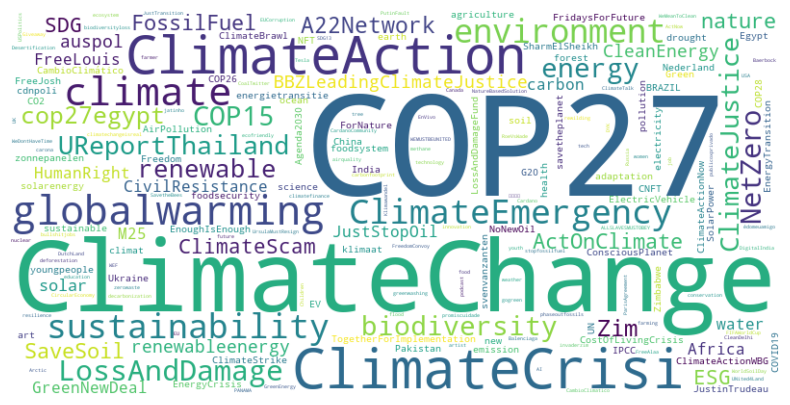

In [10]:
#combine all the hashtags from the dataframe into a single list
text = ' '.join(df_hashtags['strings'].tolist())

#create a wordcloud from the list of hashtags
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)

#display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tweet Volume Over Time

In [11]:
#check the data type of the column
df['created_at'].dtypes

dtype('O')

In [12]:
#create a column with the date of the tweet extracted from the 'created_at' column
df['tweet_date'] = pd.to_datetime(df['created_at']).dt.date


In [13]:
#confirm the column is created correctly
df['tweet_date'].head()

0    2022-12-17
1    2022-12-17
2    2022-12-17
3    2022-12-17
4    2022-12-17
Name: tweet_date, dtype: object

In [14]:
#view the earliest and latest dates
df['tweet_date'].min(), df['tweet_date'].max()

(datetime.date(2022, 10, 6), datetime.date(2022, 12, 17))

C:\Users\kaudim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kaudim\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Tweet Count')

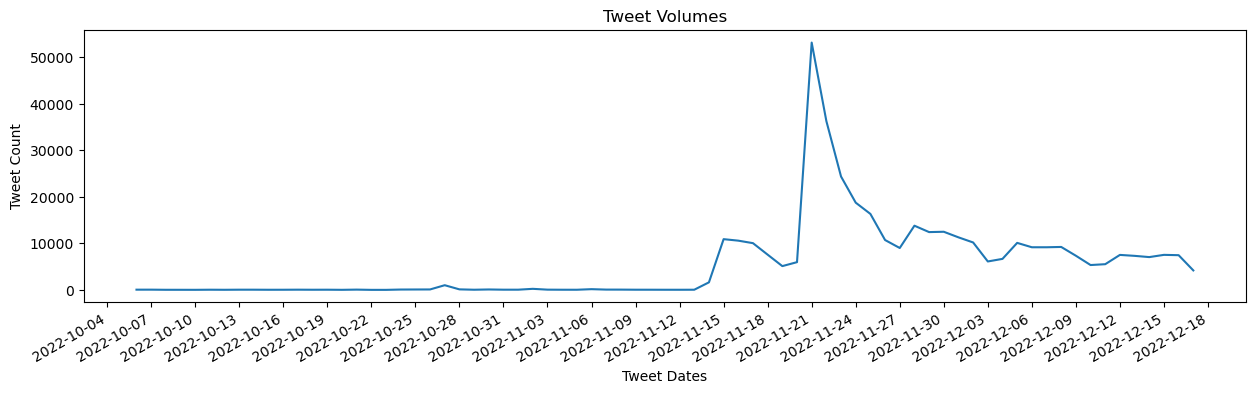

In [15]:
#count the occurrences of each date
date_counts = df['tweet_date'].value_counts().sort_index()

#create a DataFrame from the counts
date_counts_df = date_counts.reset_index()
date_counts_df.columns = ['tweet_date', 'count']

#plot the data
fig, ax = plt.subplots(figsize=(15, 4))

#plot the line chart
ax = sns.lineplot(data=date_counts_df, x='tweet_date', y='count')

#format the intervals shown on the x axis
ax.set_xticks(date_counts_df['tweet_date'])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

#autoformate the x axis
plt.gcf().autofmt_xdate()

#set the title and the x and y labels
plt.title("Tweet Volumes")
ax.set_xlabel("Tweet Dates")
ax.set_ylabel("Tweet Count")

#plt.xticks(rotation=45)

In [16]:
print(f"Day with the highest volume of tweets: {date_counts_df[date_counts_df['count'] == date_counts_df['count'].max()]['tweet_date']}")
print(f"The highest volume of tweets in a day: {date_counts_df['count'].max()}")

Day with the highest volume of tweets: 46    2022-11-21
Name: tweet_date, dtype: object
The highest volume of tweets in a day: 53187


# Top Mentioned Users

In [17]:
df.head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,in_reply_to_username,retweeted_user_id,retweeted_username,quoted_user_id,quoted_username,created_at,text,lang,source,public_metrics.impression_count,public_metrics.reply_count,public_metrics.retweet_count,public_metrics.quote_count,public_metrics.like_count,reply_settings,edit_history_tweet_ids,edit_controls.edits_remaining,edit_controls.editable_until,edit_controls.is_edit_eligible,possibly_sensitive,withheld.scope,withheld.copyright,withheld.country_codes,entities.annotations,entities.cashtags,entities.hashtags,entities.mentions,entities.urls,context_annotations,attachments.media,attachments.media_keys,attachments.poll.duration_minutes,attachments.poll.end_datetime,attachments.poll.id,attachments.poll.options,attachments.poll.voting_status,attachments.poll_ids,author.id,author.created_at,author.username,author.name,author.description,author.entities.description.cashtags,author.entities.description.hashtags,author.entities.description.mentions,author.entities.description.urls,author.entities.url.urls,author.url,author.location,author.pinned_tweet_id,author.profile_image_url,author.protected,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.listed_count,author.public_metrics.tweet_count,author.verified,author.verified_type,author.withheld.scope,author.withheld.copyright,author.withheld.country_codes,geo.coordinates.coordinates,geo.coordinates.type,geo.country,geo.country_code,geo.full_name,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version,tweet_date
0,1604264110627094528,1604264110627094528,NaN,NaN,NaN,121812371,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-17T23:55:44.000Z,Make Sure you didn't Miss Amor Shabbi Post! ht...,en,NaN,30,0,0,0,0,everyone,"[""1604264110627094528""]",5,2022-12-18T00:25:44.000Z,True,False,NaN,NaN,NaN,"[{""start"": 26, ""end"": 41, ""probability"": 0.483...",NaN,"[""#cop27"", ""#iran""]",NaN,"[""https://paper.li/f-1303473228?share_id=51d1e...","[{""domain"": {""id"": ""29"", ""name"": ""Events [Enti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121812371,2010-03-10T17:27:12.000Z,AmorShabbi,Amor Shabbi عمر شابي,"Algerian Journalist, Reporting on Sahel & MENA...",NaN,NaN,"[""@Atlas_Times""]",NaN,"[""http://www.atlas-times.com""]",http://www.atlas-times.com,"Constantine, Algeria.",NaN,https://pbs.twimg.com/profile_images/551336594...,False,4841,3404,733.0,420471,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-05T12:54:39+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0,2022-12-17
1,1604263630433751040,1604263630433751040,NaN,1.603443e+18,NaN,1080548612298420227,NaN,NaN,3.390410e+08,BBhuttoZardari,NaN,NaN,2022-12-17T23:53:49.000Z,"honor to chair conf of G77 + China, our group ...",en,NaN,24404,82,575,2,816,everyone,"[""1604263630433751040""]",5,2022-12-18T00:23:49.000Z,False,False,NaN,NaN,NaN,"[{""start"": 29, ""end"": 33, ""probability"": 0.956...",NaN,"[""#COP27""]",NaN,"[""https://twitter.com/MediaCellPPP/status/1603...","[{""domain"": {""id"": ""10"", ""name"": ""Person"", ""de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1080548612298420227,2019-01-02T19:37:19.000Z,KatiyarZulfiqar,Zulfiqar Katiyar,My uncle M saleh katiyAr e.x phone attend sec ...,NaN,"[""#information_Sec_PPP""]",NaN,NaN,NaN,NaN,"Tando Allahyar, Pakistan",1.261984e+18,https://pbs.twimg.com/profile_images/153029636...,False,541,154,1.0,76732,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-05T12:54:39+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0,2022-12-17
2,1604262860049158144,1604262860049158144,NaN,1.592630e+18,NaN,1592690413738917888,NaN,NaN,1.350488e+18,speedandscale,NaN,NaN,2022-12-17T23:50:46.000Z,ICYMI: We talked #climate and #COP27 on Monday...,en,NaN,0,14,73,4,304,everyone,"[""1604262860049158144""]",5

In [18]:
#column names in the original dataframe
df.columns

Index(['id', 'conversation_id', 'referenced_tweets.replied_to.id',
       'referenced_tweets.retweeted.id', 'referenced_tweets.quoted.id',
       'author_id', 'in_reply_to_user_id', 'in_reply_to_username',
       'retweeted_user_id', 'retweeted_username', 'quoted_user_id',
       'quoted_username', 'created_at', 'text', 'lang', 'source',
       'public_metrics.impression_count', 'public_metrics.reply_count',
       'public_metrics.retweet_count', 'public_metrics.quote_count',
       'public_metrics.like_count', 'reply_settings', 'edit_history_tweet_ids',
       'edit_controls.edits_remaining', 'edit_controls.editable_until',
       'edit_controls.is_edit_eligible', 'possibly_sensitive',
       'withheld.scope', 'withheld.copyright', 'withheld.country_codes',
       'entities.annotations', 'entities.cashtags', 'entities.hashtags',
       'entities.mentions', 'entities.urls', 'context_annotations',
       'attachments.media', 'attachments.media_keys',
       'attachments.poll.duration_mi

In [19]:
#convert all null in the column to empty space
df['entities.mentions'].fillna('', inplace=True)

In [20]:
#check data type of the column and the contents using the 3rd row as is the one with data
type(df['entities.mentions'][2]), df['entities.mentions'][2]

(str,
 '["@rypan", "@topnigel", "@UNenvoyMM", "@Investinclimate", "@AngelaAchurie"]')

In [21]:
def extract_users(text):
    '''
    Function takes in a text and returns words that tart with a '@'

    Args: 
        text: string to evaluate
    Return:
        strings that start with '@'
    '''
    return re.findall(r'@\w+', text)

#apply the function to the text column and cast it to a dataframe
df_users = pd.DataFrame(df['entities.mentions'].apply(extract_users))

df_users.head()


,entities.mentions
0,[]
1,[]
2,"[@rypan, @topnigel, @UNenvoyMM, @Investinclima..."
3,[]
4,[@metodologiaecs]


In [22]:
#all users in their own rows
df_users = df_users.explode('entities.mentions')

# convert nulls to empty space
df_users.fillna("", inplace=True)
df_users.head()

,entities.mentions
0,
1,
2,@rypan
2,@topnigel
2,@UNenvoyMM


Text(0, 0.5, 'Users Handles')

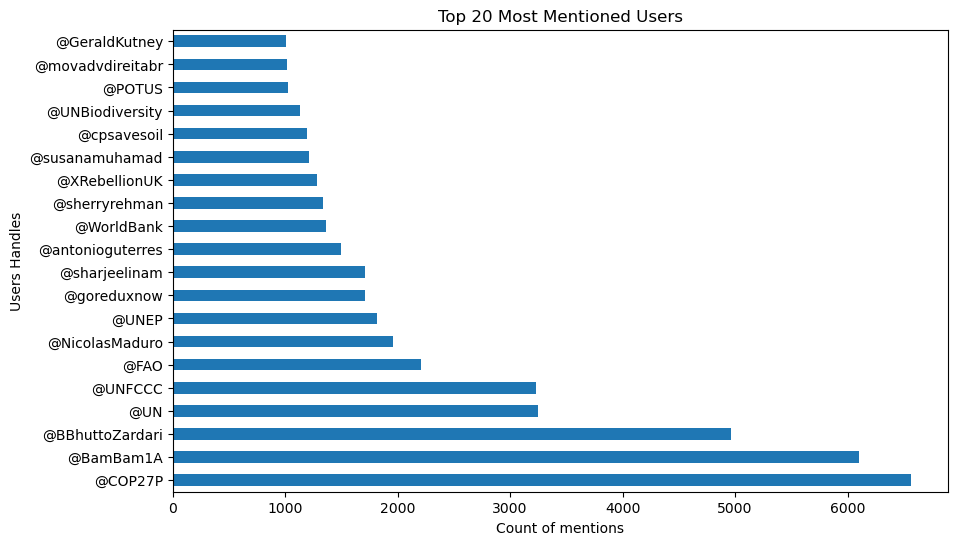

In [23]:
#count the occurences of the users and filter the top 20 excluding the empty rows
df_users_bar = df_users['entities.mentions'].value_counts()[1:21]

#initiate the plot area
fig, ax = plt.subplots(figsize=(10, 6))

#plot the horizontal bar graph
ax = df_users_bar.plot(kind='barh')

#set the labels
plt.title("Top 20 Most Mentioned Users")
ax.set_xlabel("Count of mentions")
ax.set_ylabel("Users Handles")


# Tweets From The Top Mentioned Users

In [24]:
#create a copy of the original dataframe
df_tweets = df.copy()

#enable full view of the contents of cells in the dataframes
pd.set_option('display.max_colwidth', None)


In [25]:
#tweets from the most mentioned user 'COP27P' 
df_tweets[df_tweets['author.username'] == 'COP27P'][['author.username','text', 'tweet_date']]

,author.username,text,tweet_date
5784,COP27P,Mitigation response was a core pillar at #COP27. Reducing the emission of greenhouse gases in the short run will result in important improvements in addressing the climate crisis by safeguarding the Paris Temperature Goal and keeping the 1.5 °C target within reach. https://t.co/2KQ1fNpThb,2022-12-15
9467,COP27P,“Implementation of pledges and targets is no less important than greater ambition. Those preaching about mitigation while increasing their emissions and departing from NetZero pathway need to reconsider.” @MoMoclimate speaking yesterday @aps_auc #COP27 #TogetherForImplementation https://t.co/4RrY5AKzMN,2022-12-13
10203,COP27P,"Putting #LossAndDamage on the agenda was integral to the success of #COP27, followed by a milestone consensus around supporting vulnerable developing nations to respond to the extensive damage they undergo due to the adverse effects of climate change.\n\n#TogetherForImplementation https://t.co/QNgvanTCSS",2022-12-13
20869,COP27P,"#COP27 hosted 46,000 individuals and became one of the biggest climate conferences of our time.\n\nWatch and meet some of COP27’s team as they shed light on the conference’s top achievements.\n\n#TogetherForImplementation https://t.co/A6iSVmm1t7",2022-12-08
25449,COP27P,"With the UN Biodiversity Conference, @CBD_COP15 starting today, we take a look at significant outcomes from Biodiversity Day at #COP27 and the importance of the interconnections between climate and biodiversity for a coherent framework for protection against biodiversity loss. https://t.co/K9FzMUujF7",2022-12-07
33676,COP27P,"This #WorldSoilDay, and fresh off #COP27, we recognize that to achieve food security, sustainability and adaptation, the globe needs to be mindful of keeping our ecosystems healthy.\n\nWatch to learn more about soil health and how it directly affects human well-being. https://t.co/fmc8y65gZo",2022-12-05
36551,COP27P,Sharm el Sheikh hosted thousands of participants at #COP27. \n\n@UNDPEgypt worked closely w/ the Gov’t of #Egypt to help this city become a pioneer of green energy transition in 🇪🇬.\n \n👉 Read: https://t.co/vmDuDfSMhd\n\nWatch: 👇 https://t.co/1mbUONIoVQ,2022-12-04
40363,COP27P,Watch to meet part of the #COP27 team that delivered #TogetherForImplementation on the ground in Sharm El-Sheikh.,2022-12-03
40365,COP27P,"Little over a year ago, Egypt was elected to host and preside over #COP27. Since then, a team of planners, organizers and negotiators have worked tirelessly to put together the biggest multilateral conference of our time. https://t.co/PY4p181Z7R",2022-12-03
93690,COP27P,"#LIVE on @cnn: Ensuring important strides regarding youth climate activism was a key milestone of #COP27. Watch @omniaelomrani1, COP27's Youth Envoy, talk about how COP27 made a strategic investment in inclusiveness and youth engagement. \n\n#TogetherForImplementation https://t.co/zx9Bweh34h",2022-11-25


In [26]:
#check type
df['tweet_date'].dtypes

dtype('O')

In [27]:
#convert the 'tweet_date' column to date type
df_tweets['tweet_date'] = pd.to_datetime(df['tweet_date'])

#filter COP27P tweets made on the day with the highest tweet volume
df_tweets[(df_tweets['author.username'] == 'COP27P') & (df_tweets['tweet_date'] == pd.Timestamp('2022-11-21'))][['author.username', 'text', 'tweet_date']]

,author.username,text,tweet_date
185186,COP27P,"Watch the closing remarks from #COP27 President Sameh Shoukry as Parties agreed to a historic loss and damage fund as part of the Sharm El-Sheikh Implementation Plan, at COP27. \n\n#TogetherForImplementation https://t.co/ri6F4bXSdY",2022-11-21


In [28]:
#looks like spam so people might be complaining about it
df_tweets[(df_tweets['author.username'].str.contains('BamBam1')) & (df_tweets['tweet_date'] == '2022-11-21')][['author.username','text', 'tweet_date']]

,author.username,text,tweet_date
329487,BamBam1112851,SAY IT LOUD 📢​\nSAY IT PROUD 💪​\n\n❗ถึงเวลาที่คนรุ่นใหม่จะส่งเสียงเรื่องสิ่งแวดล้อม มาจอยทีม @BamBam1A ในโครงการ #UReportThailand แล้วร่วมแสดงพลัง แลกเปลี่ยนแนวคิด และมีส่วนร่วมไปกับการแก้ปัญหา #ClimateChange 🌏​ได้ที่ https://t.co/FfOjw63GZY https://t.co/KpDFATByP0,2022-11-21
330888,BB_LoveBamBam1A,"SAY IT LOUD 📢​\nSAY IT PROUD 💪​\n\n❗ It's time for #youngpeople like you to share your thoughts on #ClimateAction.​ Join @BamBam1A team! on #UReportThailand to express your voices, exchange ideas, and contribute in addressing #ClimateChange🌏 at https://t.co/FfOjw5MDXY https://t.co/nncco4glUF",2022-11-21
333219,BamBam1_MM,"SAY IT LOUD 📢​\nSAY IT PROUD 💪​\n\n❗ It's time for #youngpeople like you to share your thoughts on #ClimateAction.​ Join @BamBam1A team! on #UReportThailand to express your voices, exchange ideas, and contribute in addressing #ClimateChange🌏 at https://t.co/FfOjw5MDXY https://t.co/nncco4glUF",2022-11-21
333222,BamBam1_MM,SAY IT LOUD 📢​\nSAY IT PROUD 💪​\n\n❗ถึงเวลาที่คนรุ่นใหม่จะส่งเสียงเรื่องสิ่งแวดล้อม มาจอยทีม @BamBam1A ในโครงการ #UReportThailand แล้วร่วมแสดงพลัง แลกเปลี่ยนแนวคิด และมีส่วนร่วมไปกับการแก้ปัญหา #ClimateChange 🌏​ได้ที่ https://t.co/FfOjw63GZY https://t.co/KpDFATByP0,2022-11-21
333949,BamBam1112851,"ฝากเข้าไปกด ❤️ , คอมเม้นท์ใน ig หน่อยค้าบเพื่อดันยอน engagement😍\n#BamBam #WhoAreYou #WheelsUp #SlowMo @BamBam1A #Climatechange \n🔗 https://t.co/dmTy9ATM00",2022-11-21
335848,BB_LoveBamBam1A,SAY IT LOUD 📢​\nSAY IT PROUD 💪​\n\n❗ถึงเวลาที่คนรุ่นใหม่จะส่งเสียงเรื่องสิ่งแวดล้อม มาจอยทีม @BamBam1A ในโครงการ #UReportThailand แล้วร่วมแสดงพลัง แลกเปลี่ยนแนวคิด และมีส่วนร่วมไปกับการแก้ปัญหา #ClimateChange 🌏​ได้ที่ https://t.co/FfOjw63GZY https://t.co/KpDFATByP0,2022-11-21
336124,ILoveBamBam19,SAY IT LOUD 📢​\nSAY IT PROUD 💪​\n\n❗ถึงเวลาที่คนรุ่นใหม่จะส่งเสียงเรื่องสิ่งแวดล้อม มาจอยทีม @BamBam1A ในโครงการ #UReportThailand แล้วร่วมแสดงพลัง แลกเปลี่ยนแนวคิด และมีส่วนร่วมไปกับการแก้ปัญหา #ClimateChange 🌏​ได้ที่ https://t.co/FfOjw63GZY https://t.co/KpDFATByP0,2022-11-21
336575,BamBam1a_BB1a,SAY IT LOUD 📢​\nSAY IT PROUD 💪​\n\n❗ถึงเวลาที่คนรุ่นใหม่จะส่งเสียงเรื่องสิ่งแวดล้อม มาจอยทีม @BamBam1A ในโครงการ #UReportThailand แล้วร่วมแสดงพลัง แลกเปลี่ยนแนวคิด และมีส่วนร่วมไปกับการแก้ปัญหา #ClimateChange 🌏​ได้ที่ https://t.co/FfOjw63GZY https://t.co/KpDFATByP0,2022-11-21


In [29]:
df_tweets[(df_tweets['author.username'] == 'BBhuttoZardari')][['author.username','text', 'tweet_date']]

,author.username,text,tweet_date
3648,BBhuttoZardari,"Finally, appreciated Ministers’ kind words said for leadership of 🇵🇰 as Chair of G77 &amp; China for several tangible advances during its presidency including the establishment of the Loss &amp; Damage Fund at #CoP27. 7/7",2022-12-16
4994,BBhuttoZardari,"honor to chair conf of G77 + China, our group represents developing world. Many members commended leadership of 🇵🇰 at #COP27 where G77 proposal to include loss &amp; damage on agenda was accepted. Today we demand reforming international system so it works for all not just the few. https://t.co/nC8AVP7zmy",2022-12-15
16031,BBhuttoZardari,"In a new article, @BBhuttoZardari, Foreign Minister of Pakistan, discusses the devastating impacts of climate change in 2022 and the importance of the loss and damage facility, adopted at #COP27, for the most vulnerable countries. #ClimateAction \n\n➡️ https://t.co/FSyWsUVMWY https://t.co/Yt1BvJTeUB",2022-12-10


In [30]:
df_tweets[(df_tweets['author.username'] == 'UN') & (df_tweets['tweet_date'] == '2022-11-21')][['author.username','text', 'tweet_date']]

,author.username,text,tweet_date
176157,UN,#COP27 concluded in Sharm El-Sheikh with a breakthrough agreement on a new “Loss and Damage” fund for vulnerable countries.\n\nhttps://t.co/cxvWR3Xn2D,2022-11-21
179211,UN,#COP27 reached a breakthrough agreement on a new “Loss and Damage” fund for vulnerable countries.\n\nIt also resulted in countries delivering a package of decisions that reaffirmed their commitment to limit global temperature rise to 1.5°C.,2022-11-21


In [31]:
df_tweets[(df_tweets['author.username'] == 'FAO') & (df_tweets['tweet_date'] == '2022-11-21')][['text', 'tweet_date']]

,text,tweet_date
327528,"Lakeshore development, pollution, #ClimateChange &amp; overfishing have impacted Lake Shkodër’s biodiversity, affecting the livelihoods of local fishing communities.\n\nWhat @FAO is doing to keep these fishing communities alive 👉https://t.co/oVoPgTFDvM\n\n#WorldFisheriesDay #IYAFA2022",2022-11-21


In [32]:
#This user did not tweet over the period of the dataset but had considerable mentions
df_tweets[(df_tweets['author.username'] == 'NicolasMaduro') & (df_tweets['tweet_date'] == '2022-11-21')][['text', 'tweet_date']]

,text,tweet_date


In [33]:
df_tweets[(df_tweets['author.username'] == 'NicolasMaduro')][['text', 'tweet_date']]

,text,tweet_date
